In [1]:
import pandas as pd
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime

In [2]:
filename = "sap_storing_data_hu_project.csv" 
df_not_cleaned = pd.read_csv(filename, low_memory=False)
#verwijder alle kolommen die niet van gebruik zijn:
df = df_not_cleaned.drop(columns=['stm_sap_mon_meld_ddt', 'stm_mon_begin_ddt', 'stm_mon_toelichting_trdl', 'stm_oh_pg_mld', 'stm_geo_mld_uit_functiepl', 'stm_scenario_mon', 'stm_status_melding_sap', 'stm_mon_nr_status_omschr', 'stm_mon_nr__statuscode', 'stm_mon_nr_status_wijzdd', 'stm_aanntpl_ddt', 'stm_geo_gst_uit_functiepl', 'stm_objectdl_code_gst', 'stm_objectdl_groep_gst', 'stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt', 'stm_progfh_gw_ddt', 'stm_progfh_gw_lwd_ddt', 'stm_progfh_hz', 'stm_veroorz_groep', 'stm_veroorz_code', 'stm_progfh_gw_duur', 'stm_progfh_gw_lwd_tijd', 'stm_progfh_gw_lwd_datum', 'stm_progfh_gw_datum', 'stm_arbeid', 'stm_functiepl_gst', 'stm_functiepl_mld', 'stm_mon_begintijd', 'stm_mon_begindatum', 'stm_aangelegd_tijd', 'stm_aangelegd_dd', 'stm_dir_betrok_tr', 'stm_evb', 'stm_mon_vhdsincident', 'stm_mon_eind_ddt', 'stm_afspr_aanvangddt', 'stm_effect', 'stm_veroorz_tekst_kort', 'stm_projnr', 'stm_wbi_nummer', 'stm_status_gebr', 'stm_standplaats', 'stm_actie', 'stm_hinderwaarde', 'stm_rec_toegev_ddt', 'stm_afsluit_tijd', 'stm_afsluit_dd', 'stm_afsluit_ddt', 'stm_akkoord_melding_jn', 'stm_fact_jn', 'stm_status_sapnaarmon', 'stm_akkoord_mon_toewijz', 'stm_controle_dd', 'stm_mon_eind_tijd', 'stm_mon_eind_datum', 'stm_reactie_duur', 'stm_afspr_aanvangtijd', 'stm_afspr_aanvangdd', 'stm_historie_toelichting', 'stm_schade_verhaalb_jn', 'stm_x_bron_arch_dt', 'stm_x_bron_bestandsnaam', 'stm_x_bron_publ_dt', 'stm_rapportage_jaar', 'stm_rapportage_maand', 'stm_sorteerveld', 'stm_afspr_func_hersteltijd', 'stm_afspr_func_hersteldd', 'stm_relatiervo', 'stm_relatiervo_volgend', 'stm_relatiervo_vorig', 'stm_schade_statusdatum', 'stm_schade_status_ga', 'stm_schadenr', 'stm_x_start_sessie_dt', 'stm_x_bk', 'stm_x_run_id', 'stm_x_actueel_ind', 'stm_x_vervallen_ind'])
print("Done")

Done


# Data cleaning:


De te bepalen welke variabelen het meest van toepassing zijn om te gebruiken kijken we naar welke
kolommen informatie geven over de tijd van de melding, monteur. Tijd wanneer de melding word opgelost.
Wat voor melding het is en info over de melding/storing, en de locatie. Zo zijn de volgende kolommen
het meest van toepassing:

Over soort melding
- stm_sap_meldtekst (melding omschrijving)
- stm_geo_mld (melding code) - nodig
- stm_oorz_code (oorzaak code) - nodig
- stm_prioriteit (prioriteit)

Over tijd:
- stm_sap_melddatum (datump melding) - nodig
- stm_sap_meldtijd (tijdstip melding) - nodig
- stm_aanngeb_dd (datum aannemer gebeld)
- stm_aanngeb_tijd (tijd aannemer gebeld)
- stm_aanntpl_dd (datum aannemer op plek)
- stm_aanntpl_tijd (tijd aannemer op plek)

- stm_fh_dd (Datum van functie herstel) - nodig
- stm_fh_tijd (Tijdstip van functieherstel) - nodig
- stm_sap_storeinddatum (Datum einde storing) - nodig
- stm_sap_storeindtijd (Tijdstip einde storing) - nodig
- stm_fh_duur (Duur van functiehersteltijd) - nodig

Over equipment:
- stm_equipm_nr_mld (equipment)
- stm_equipm_omschr_mld (equipment omschrijving)

Over locatie
- stm_km_van_mld (locatie van)
- stm_km_tot_mld (locatie tot)
- stm_vl_post (VL post) - nodig
- stm_contractgeb_mld(locatie melding) - nodig
- stm_pplg_van (PPLG van locatie)
- stm_pplg_naar (PPLG tot locatie)
- stm_dstrglp_van (Dienstregelpunt van locatie)
- stm_dstrglp_naar (Dienstregelpunt tot locatie)

Over prognose:
- stm_progfh_in_datum (Datum prognose)
- stm_progfh_in_tijd (Tijdstip FHT prognose)
- stm_progfh_in_invoer_dat (Invoer datum prognose)
- stm_progfh_in_invoer_tijd (Invoer tijdstip FHT prognose)
- stm_progfh_in_duur (Duur FHT)



In [3]:
#deze functie verwijdert alle rijen waar geen value op de gegeven kolommen zitten
def drop_rows_with_null(lst, df):
    dfisnull = df.isnull()[lst]
    matches = dfisnull[(dfisnull).any(axis=1)]
    return df.drop(matches.index)

In [4]:
#Deze functie berkent de uitschiet grenzen
def uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*1.5)
    minuitschieter = q1 - (iqr*1.5)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van uitschieters in een kolom
def return_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder uitschieters
def return_kolom_zonder_uitschieters(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom


In [5]:
#Deze functie berkent de extreme uitschiet grenzen
def ex_uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*3)
    minuitschieter = q1 - (iqr*3)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van extreme uitschieters in een kolom
def return_ex_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder extreme uitschieters
def return_kolom_zonder_ex_uitschieters(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom

In [6]:
# Verwijder de rijen die geen value bevatten in de benodigde kolommen
df_filtered = drop_rows_with_null(['stm_geo_mld', 'stm_sap_melddatum', 'stm_oorz_code', 'stm_sap_meldtijd',
                          'stm_fh_dd', 'stm_fh_tijd','stm_oorz_groep',
                          'stm_fh_duur'], df)
print(len(df))
print(len(df_filtered))
df_filtered

898526
737230


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
1,1,50053211,0.0,NaN,02/01/2006 09:00:00,Logboeknr Geeltje : 49 Tijd: 0900 VL-Po...,Logboeknr Geeltje : 49 Tijd: 0900,624.0,NaN,NaN,...,02/01/2006,09:00:00,0.0,02/01/2006,09:00:00,NaN,NaN,NaN,NaN,NaN
2,2,50053213,48.0,GN,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-Post: ...,Logboeknr RBV : 48 Tijd: 1235 VL-P,201.0,NaN,NaN,...,02/01/2006,13:26:00,51.0,02/01/2006,13:26:00,schapen op de spoorbaan!,NaN,NaN,Lp,Apg
3,3,50053214,72.0,ZL,02/01/2006 16:40:00,Logboeknr RBV : 72 Tijd: 1640 VL-Post: ...,Logboeknr RBV : 72 Tijd: 1640 VL-P,25.0,NaN,NaN,...,02/01/2006,17:20:00,40.0,02/01/2006,17:20:00,Persoon langs de baan,NaN,NaN,Hgl,NaN
4,4,50053215,96.0,ZL,02/01/2006 22:30:00,Logboeknr RBV : 96 Tijd: 2230 VL-Post: ...,Logboeknr RBV : 96 Tijd: 2230 VL-P,12.0,NaN,NaN,...,02/01/2006,22:36:00,6.0,02/01/2006,22:36:00,Bijna aanrijding met persoon,NaN,NaN,Hgv,NaN
5,5,50053218,38.0,EHV,02/01/2006 11:23:00,Logboeknr RBV : 38 Tijd: 1123 VL-Post: ...,Logboeknr RBV : 38 Tijd: 1123 VL-P,614.0,10621391.0,DETECTREIN,...,02/01/2006,11:30:00,7.0,NaN,00:00:00,Geen SMC-melding.Geen onderzoek geweest.,NaN,NaN,Ht,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898521,908625,99003505,0.0,NaN,11/05/2013 08:06:00,GVC : sp-2 en 3 stop lampen op de stootjukke...,GVC : sp-2 en 3 stop lampen op de stoot,560.0,NaN,NaN,...,11/05/2013,09:29:00,83.0,11/05/2013,09:30:00,NaN,NaN,NaN,NaN,11/05/2013
898522,908626,99003506,0.0,NaN,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,Whz : Ovw 100.1 albert Plesmanweg blijft,468.0,10021085.0,OVERWEG,...,11/05/2013,10:44:00,83.0,11/05/2013,10:44:00,NaN,NaN,NaN,NaN,NaN
898523,908627,99003506,0.0,NaN,11/05/2013 09:21:00,Whz : Ovw 100.1 albert Plesmanweg blijft dic...,Whz : Ovw 100.1 albert Plesmanweg blijft,468.0,10021085.0,OVERWEG,...,11/05/2013,10:44:00,83.0,11/05/2013,10:44:00,NaN,NaN,NaN,NaN,00/00/0000
898524,908628,99999999,0.0,NaN,20/08/2016 14:15:17,Bdg-Apn : Km 12.7 twee gedode zwanen langs het...,Bdg-Apn : Km 12.7 twee gedode zwanen lan,102.0,NaN,NaN,...,20/08/2016,15:14:00,19.0,20/08/2016,15:15:00,Gestoord object: SPOOR LA. Gestoord onde,NaN,NaN,NaN,NaN


In [7]:
df_filtered.drop_duplicates(subset ="#stm_sap_meldnr", 
                     keep = False, inplace = True)

In [8]:
len(df_filtered)

325512

# Data preparation:

In [9]:
df_filtered['stm_sap_meld_ddt'] = df_filtered['stm_sap_meld_ddt'].apply(pd.to_datetime) # maakt het type: datetime

In [10]:
df_year = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.year)
df_filtered.insert(5, 'Jaar', df_year) # zet het jaar los in de tabel

In [11]:
df_day = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.dayofyear)
df_filtered.insert(6, 'Dag_van_jaar', df_day) # zet de dag count van het jaar los in de tabel (1-365)

In [12]:
df_hour = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.hour)
df_filtered.insert(7, 'Uur_van_dag', df_hour) # zet het uur van de dag los in de tabel (0-23)

In [13]:
df_min = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.minute)
df_filtered.insert(8, 'Minuut_van_uur', df_min) # zet de minuten van het uur los in de tabel (0-59)

In [14]:
df_hour_min = (df_filtered['Uur_van_dag'] * 60) + df_filtered['Minuut_van_uur']
df_filtered.insert(9, 'Minuut_van_dag', df_hour_min) # zet de minuut van de dag in een tabel (0-1440)

In [15]:
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
df_filtered = (df_filtered.loc[(df_filtered['stm_fh_duur'] > 5) & (df_filtered['stm_fh_duur'] < 360)])
df_filtered


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,Jaar,Dag_van_jaar,Uur_van_dag,Minuut_van_uur,Minuut_van_dag,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
2,2,50053213,48.0,GN,2006-02-01 12:35:00,2006,32,12,35,755,...,02/01/2006,13:26:00,51.0,02/01/2006,13:26:00,schapen op de spoorbaan!,NaN,NaN,Lp,Apg
3,3,50053214,72.0,ZL,2006-02-01 16:40:00,2006,32,16,40,1000,...,02/01/2006,17:20:00,40.0,02/01/2006,17:20:00,Persoon langs de baan,NaN,NaN,Hgl,NaN
4,4,50053215,96.0,ZL,2006-02-01 22:30:00,2006,32,22,30,1350,...,02/01/2006,22:36:00,6.0,02/01/2006,22:36:00,Bijna aanrijding met persoon,NaN,NaN,Hgv,NaN
5,5,50053218,38.0,EHV,2006-02-01 11:23:00,2006,32,11,23,683,...,02/01/2006,11:30:00,7.0,NaN,00:00:00,Geen SMC-melding.Geen onderzoek geweest.,NaN,NaN,Ht,NaN
6,6,50053219,99.0,EHV,2006-02-01 23:25:00,2006,32,23,25,1405,...,02/01/2006,23:38:00,13.0,03/01/2006,09:44:00,Geen SMC-melding.,NaN,NaN,Tb,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898277,908381,99003153,0.0,NaN,2012-02-09 12:22:00,2012,40,12,22,742,...,02/09/2012,13:21:00,58.0,02/09/2012,13:22:00,NaN,NaN,NaN,NaN,NaN
898316,908420,99003170,0.0,NaN,2013-01-08 12:01:00,2013,8,12,1,721,...,01/08/2013,12:09:00,8.0,01/08/2013,12:10:00,NaN,NaN,NaN,NaN,00/00/0000
898317,908421,99003172,0.0,NaN,2013-08-17 12:57:00,2013,229,12,57,777,...,17/08/2013,13:08:00,10.0,17/08/2013,13:50:00,NaN,NaN,NaN,NaN,00/00/0000
898322,908426,99003175,0.0,NaN,2013-10-19 13:23:00,2013,292,13,23,803,...,19/10/2013,15:42:00,139.0,19/10/2013,15:43:00,NaN,NaN,NaN,NaN,19/10/2013


In [16]:
# minuut van de dag dat de aannemer ter plekken is gekomen lijst gemaakt en in dataset gezet.
df_filtered['stm_aanntpl_tijd'] = df_filtered['stm_aanntpl_tijd'].apply(pd.to_datetime)
df_hour = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.hour)
df_filtered.insert(0, 'Uur_herstel', df_hour)
df_min = pd.DataFrame(df_filtered['stm_aanntpl_tijd'].dt.minute)
df_filtered.insert(1, 'Min_van_uur_herstel', df_min)
df_min_of_day_herstel = (df_filtered['Uur_herstel'] * 60) + df_filtered['Min_van_uur_herstel']
df_filtered.insert(2, 'Minuut_van_dag_herstel', df_min_of_day_herstel)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

<ipython-input-16-e2cb031b2713>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['stm_aanntpl_tijd'] = df_filtered['stm_aanntpl_tijd'].apply(pd.to_datetime)


In [17]:
# minuut van de dag dat de aannemer klaar is lijst gemaakt en in dataset gezet.
df_filtered['stm_fh_ddt'] = df_filtered['stm_fh_ddt'].apply(pd.to_datetime)
df_hour2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.hour)
df_filtered.insert(3, 'Uur_hersteld', df_hour2)
df_min2 = pd.DataFrame(df_filtered['stm_fh_ddt'].dt.minute)
df_filtered.insert(4, 'Min_van_uur_hersteld', df_min2)
df_min_of_day_herstel2 = (df_filtered['Uur_hersteld'] * 60) + df_filtered['Min_van_uur_hersteld']
df_filtered.insert(5, 'Minuut_van_dag_hersteld', df_min_of_day_herstel2)
# Eigenlijk precies hetzelfde als hier boven maar dan in 1 cel

<ipython-input-17-6c0389443f03>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['stm_fh_ddt'] = df_filtered['stm_fh_ddt'].apply(pd.to_datetime)


In [18]:
Echte_herstel_tijd = df_filtered['Minuut_van_dag_hersteld'] - df_filtered['Minuut_van_dag_herstel']
df_filtered.insert(6, 'Echte_hersteltijd', Echte_herstel_tijd)
# berekent het verschil tussen de minuten van de dag (dus het berekent eigenlijk de reparatie tijd, 
# van aankomst aannemer tot gefixt)

In [19]:
# hoger dan 5 minuten,als het onder de 5 minuten zit is er een goede kans dat het een fout was.
#onder de 360 min (6 uur) de productowner had dit als waarde aan ons gegeven. 
df_filtered = (df_filtered.loc[(df_filtered['Echte_hersteltijd'] > 5) & (df_filtered['Echte_hersteltijd'] < 360)])

# Baseline
Target variabele is 'stm_fh_duur'. Dit is de functie hersteltijd dit houd in dat vanaf de melding tot dat het probleem opgelost is getimed wordt. 

baseline:  

In [20]:
# De target variabele filteren tussen de 0 min en 360 min. Prodcut ower gaf dit als grens aan. 
#data_fht = df_filtered['stm_fh_duur'].loc[(df_filtered['stm_fh_duur'] > 0) & (df_filtered['stm_fh_duur'] < 360)]
data_fht = df_filtered['Echte_hersteltijd'].loc[(df_filtered['Echte_hersteltijd'] > 0) & (df_filtered['Echte_hersteltijd'] < 360)]
data_fht

31         62.0
44         40.0
45        214.0
65         49.0
101       350.0
          ...  
898274    215.0
898275     34.0
898277     20.0
898322     29.0
898422    282.0
Name: Echte_hersteltijd, Length: 173749, dtype: float64

In [21]:
data_fht.describe()

count    173749.000000
mean         57.258390
std          56.968584
min           6.000000
25%          20.000000
50%          38.000000
75%          72.000000
max         359.000000
Name: Echte_hersteltijd, dtype: float64

In [22]:
data_fht.mean()

57.258389976345185

In [23]:
data_fht.median()

38.0

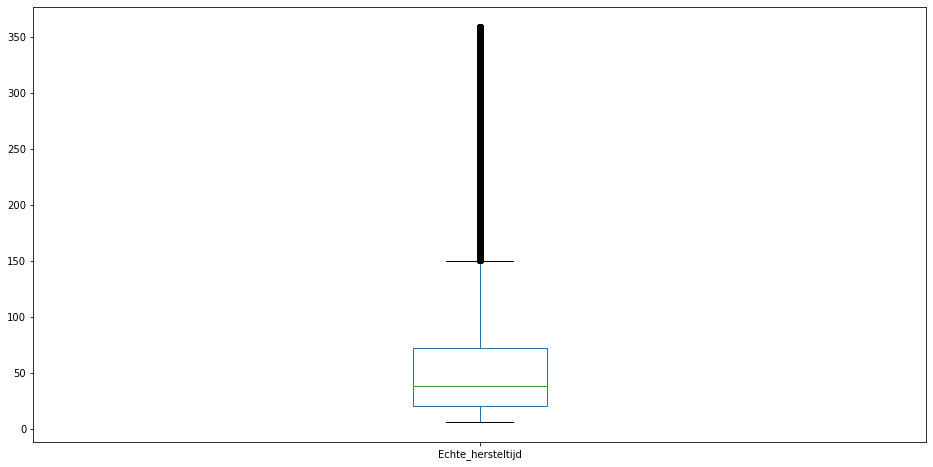

In [24]:
data_fht.plot.box(figsize=(16,8))

In [25]:
len(data_fht[data_fht < data_fht.mean()])

115023

In [26]:
len(data_fht[data_fht < data_fht.mean()])/len(data_fht)*100

66.20066878082753

In [27]:
len(data_fht[data_fht < data_fht.median()])/len(data_fht)*100

49.83107816447864

65% van alle herstel tijden zit onder het gemiddelde (102 min)

49% van alle herstel tijden zit onder de mediaan (82 min)



In [28]:
data_fht = data_fht.to_frame()
#data_fht['mediaan'] = data_fht['stm_fh_duur'].median()
data_fht['mediaan'] = data_fht['Echte_hersteltijd'].median()
#data_fht['mean'] = data_fht['stm_fh_duur'].mean()
data_fht['mean'] = data_fht['Echte_hersteltijd'].mean()
data_fht.head()

,Echte_hersteltijd,mediaan,mean
31,62.0,38.0,57.25839
44,40.0,38.0,57.25839
45,214.0,38.0,57.25839
65,49.0,38.0,57.25839
101,350.0,38.0,57.25839


In [29]:
# de score bepalen aan de hand van de RSME
#np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mean']))
np.sqrt(mean_squared_error(data_fht.loc[:,'Echte_hersteltijd'],data_fht.loc[:,'mean']))

56.96841997740195

In [30]:
#de score bepalen aan de hand van de RSME
#np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mediaan']))
np.sqrt(mean_squared_error(data_fht.loc[:,'Echte_hersteltijd'],data_fht.loc[:,'mediaan']))

60.13556733915997

# KNeighborsclassifier


In [31]:
X = df_filtered[['stm_km_van_mld','stm_oorz_code' ,'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']] # oude niet 'echte' hersteltijd.
y = df_filtered[['Echte_hersteltijd']]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=None)

In [33]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()

clf

KNeighborsClassifier()

In [34]:
clf.fit(X_train, y_train)

<ipython-input-34-4f66baab8f93>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  clf.fit(X_train, y_train)


KNeighborsClassifier()

In [35]:
y_pred_train = clf.predict(X_train)

y_pred_test = clf.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

print('Accuracy traindata')
print(accuracy_score(y_train, y_pred_train))

print('')
print('Accuracy testdata')
print(accuracy_score(y_test, y_pred_test))

Accuracy traindata
0.2278447823807027

Accuracy testdata
0.021237410071942447


In [37]:
y_pred_test_KN = clf.predict(X_test)

error_metric_KN = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric_KN)

69.94063093878341


In [38]:
df_filtered['stm_km_van_mld'].describe()

count    1.737490e+05
mean     3.216044e+04
std      1.403069e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.293000e+04
75%      4.395000e+04
max      5.058500e+07
Name: stm_km_van_mld, dtype: float64

# linear regression 

In [84]:
X = df_filtered[['stm_km_van_mld', 'stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']]
y= df_filtered[['Echte_hersteltijd']]

In [85]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.1, random_state=None) 

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
linear_reg_model = LinearRegression()

In [88]:
linear_reg_model.fit(X_train, y_train)

LinearRegression()

In [89]:
from sklearn.metrics import mean_squared_error

y_pred_test = linear_reg_model.predict(X_test)

error_metric = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric)

57.13778528005483


Text(0.5, 1.0, 'voorspelling tegen over daadwerkelijke data')

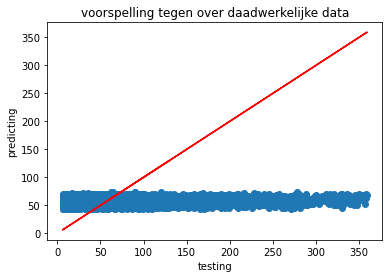

In [90]:
# model plotten en lineare regressie er in verwerken
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_test)
ax.plot(y_test, y_test, color='red')
ax.set_xlabel('testing')
ax.set_ylabel('predicting')
ax.set_title('voorspelling tegen over daadwerkelijke data')

In [91]:
from collections import OrderedDict
new_data = OrderedDict([
    ('stm_km_van_mld',40),
    ('stm_prioriteit',6),
    ('Dag_van_jaar',150),
    ('Jaar',2020),
    ('Minuut_van_dag', 940)
])

new_data = pd.Series(new_data).values.reshape(1,-1)

linear_reg_model.predict(new_data)

array([[54.69104572]])

Het linear regression model geeft een RMSE van 55.9 

In [47]:
len(df_filtered)

173749

# Decision Tree


In [48]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [49]:
df_filtered['stm_oorz_groep']

31        ONR-DERD
44        ONR-DERD
45        ONR-DERD
65        ONR-DERD
101           WEER
            ...   
898274     ONR-RIB
898275     TECHONV
898277     TECHONV
898322    ONR-DERD
898422     TECHONV
Name: stm_oorz_groep, Length: 173749, dtype: object

In [57]:
df2  = pd.get_dummies(df_filtered, columns=["stm_oorz_groep"])
df2

,Uur_herstel,Min_van_uur_herstel,Minuut_van_dag_herstel,Uur_hersteld,Min_van_uur_hersteld,Minuut_van_dag_hersteld,Echte_hersteltijd,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,...,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_oorz_groep_ONR-DERD,stm_oorz_groep_ONR-RIB,stm_oorz_groep_TECHONV,stm_oorz_groep_WEER
31,0,0,0,1.0,2.0,62.0,62.0,31,50053257,0.0,...,01:02:00,Suicidaal persoon langs het spoor.,NaN,NaN,NaN,NaN,1,0,0,0
44,0,0,0,0.0,40.0,40.0,40.0,44,50053290,0.0,...,00:40:00,Mcn meldt suicidaal persoon thv station.,NaN,NaN,NaN,NaN,1,0,0,0
45,0,0,0,3.0,34.0,214.0,214.0,45,50053292,0.0,...,03:34:00,op overweg 22.9 zijn fietsen neergelegd>,NaN,NaN,NaN,NaN,1,0,0,0
65,0,0,0,0.0,49.0,49.0,49.0,67,50053366,1.0,...,00:49:00,ree,NaN,NaN,Dv,Apda,1,0,0,0
101,0,0,0,5.0,50.0,350.0,350.0,103,50053412,7.0,...,05:50:00,Rijp op bovenleiding,NaN,NaN,Hde,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898274,8,17,497,11.0,52.0,712.0,215.0,908378,99003150,0.0,...,00:00:00,NaN,NaN,NaN,NaN,NaN,0,1,0,0
898275,11,20,680,11.0,54.0,714.0,34.0,908379,99003151,0.0,...,11:54:00,NaN,NaN,NaN,NaN,NaN,0,0,1,0
898277,13,1,781,13.0,21.0,801.0,20.0,908381,99003153,0.0,...,13:22:00,NaN,NaN,NaN,NaN,NaN,0,0,1,0
898322,15,13,913,15.0,42.0,942.0,29.0,908426,99003175,0.0,...,15:43:00,NaN,NaN,NaN,NaN,19/10/2013,1,0,0,0


In [59]:
X = df2[['stm_km_van_mld','stm_oorz_code','stm_geo_mld','stm_oorz_groep_WEER','stm_prioriteit', 'Dag_van_jaar', 'Jaar', 'Minuut_van_dag']]
#y = df_filtered[['stm_fh_duur']] # oude niet 'echte' hersteltijd.
y = df2[['Echte_hersteltijd']]

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [73]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [74]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.016115107913669064


In [75]:
y_pred_test_TC = clf.predict(X_test)

error_metric_TC = np.sqrt(mean_squared_error(y_pred=y_pred_test, y_true=y_test))
print(error_metric_TC)

57.12592820518196


In [ ]:
df_filtered['stm_contractgeb_mld']

In [ ]:
df_filtered['stm_geo_mld']

In [ ]:
df_filtered['stm_oorz_groep']